In [2]:
import sys
sys.path.append('../component')  # Ensure sys is imported before using it
import pandas as pd
from utils import *
from class_ARIMA_model import ARIMA_model
from class_EDA import *
import os
os.getcwd()

'/home/ubuntu/Capstone_Group_1/code/main_code'

### Check raw data, prepare data for model

In [3]:
path = '../data/weather.csv'
eda = EDA(path)
df = eda.read_data()

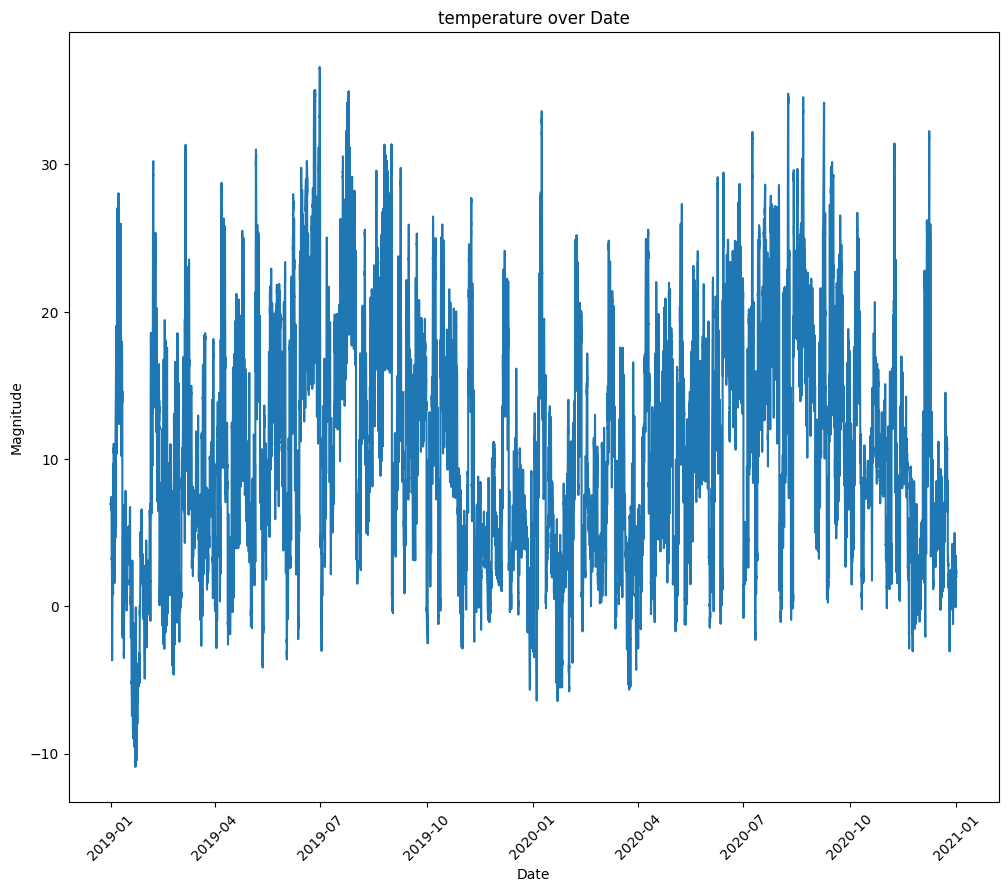

In [8]:
# the line plot of the target
eda.ts_plots(df)

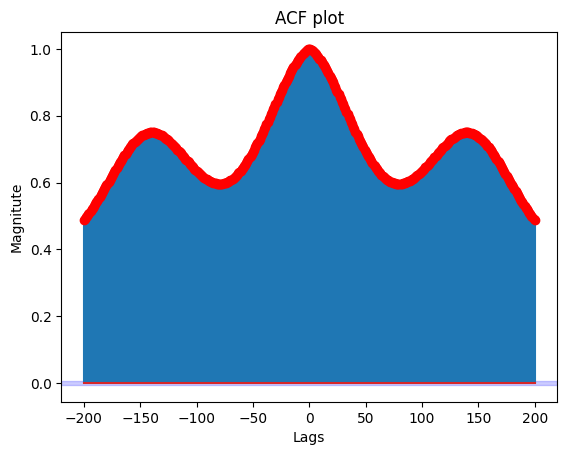

In [4]:
# the ACF plot of the target
eda.acf_plot(df, 200, Col=1)

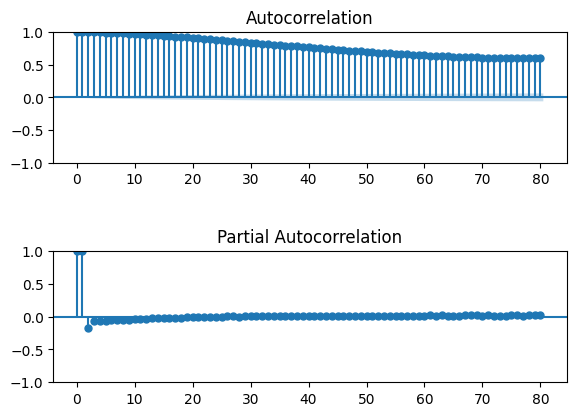

In [10]:
# the ACF and PACF plot
eda.acf_pacf_plot(df, 80, Col=1)

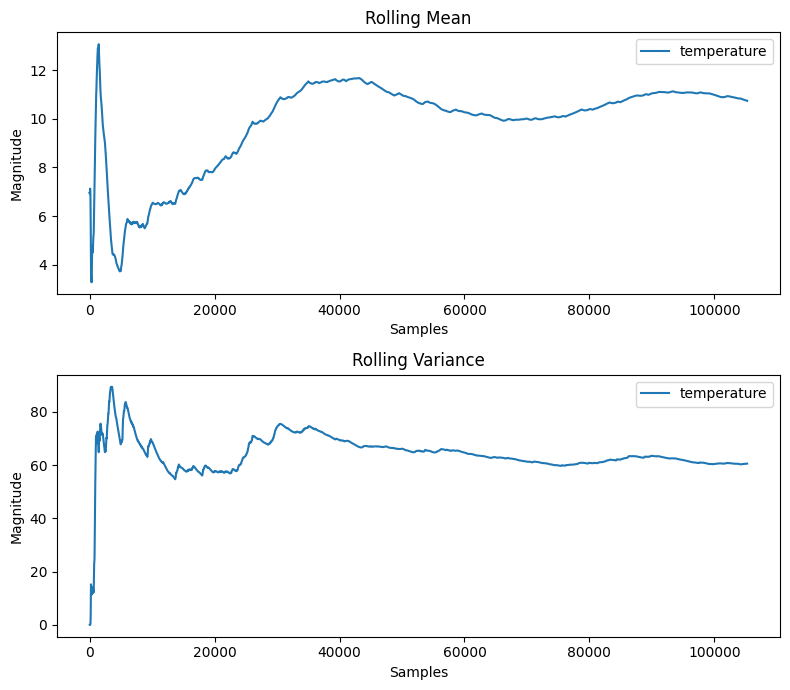

In [5]:
# the rolling mean and variance
eda.rolling_mean_var(df, Col=1)

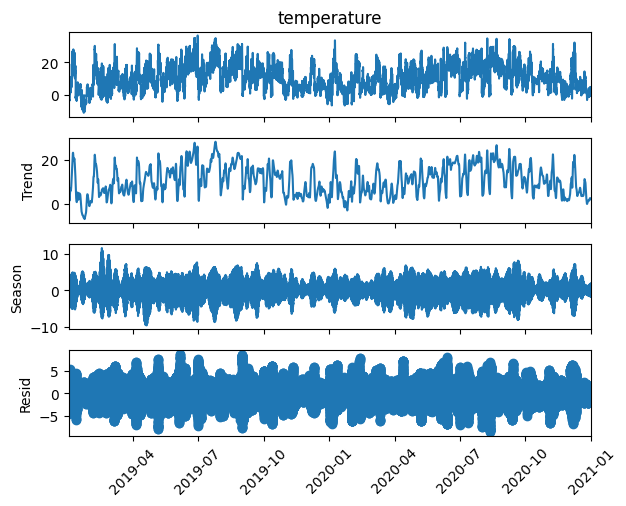

The strength of trend for this data set is 94.33%
The strength of seasonality for this data set is  74.79%


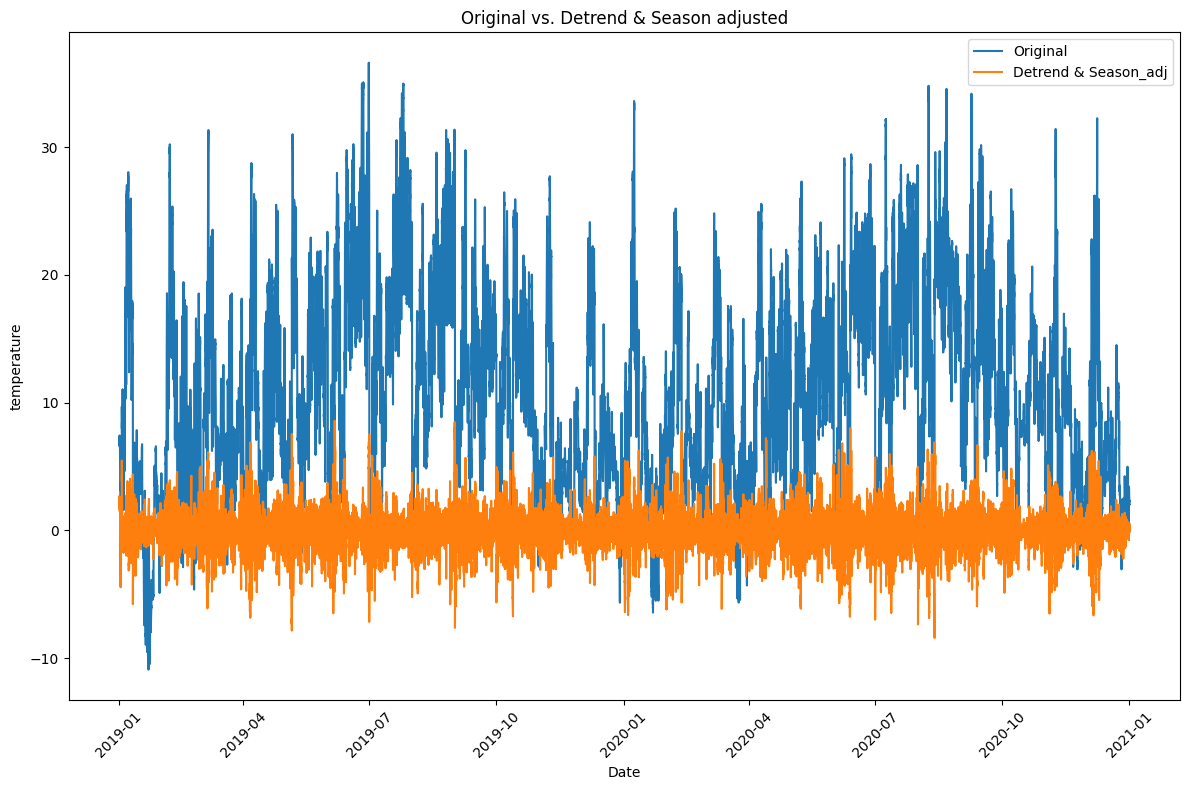

In [4]:
# the time series decomposition 
eda.decomposition(df, 144, Col=1)

In [8]:
eda.stationarity(df)

ADF Statistic: -12.701473
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Pass ADF test.
Results of KPSS Test:
p-value: 0.010000
Test Statistic             1.294409
p-value                    0.010000
Lags Used                191.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Fail to pass KPSS test.


/home/ubuntu/Capstone_Group_1/code/main_code/../component/utils.py:91: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")


In [3]:
# prepare the data for the model
df = pd.read_csv('../data/weather.csv', parse_dates=['date'])

train_size = df.shape[0] * 0.8
df_train = df[:train_size]
df_test = df[train_size:]

df_train['date'] = pd.to_datetime(df_train['date'])
df_train.set_index('date', inplace=True)

df_test['date'] = pd.to_datetime(df_test['date'])
df_test.set_index('date', inplace=True)

train = df_train['temperature'].values.reshape(-1, 1)
test = df_test['temperature'].values.reshape(-1, 1)

print('Train shape', train.shape, '\n', 'Test shape', test.shape)


(73684, 1)


# ARIMA

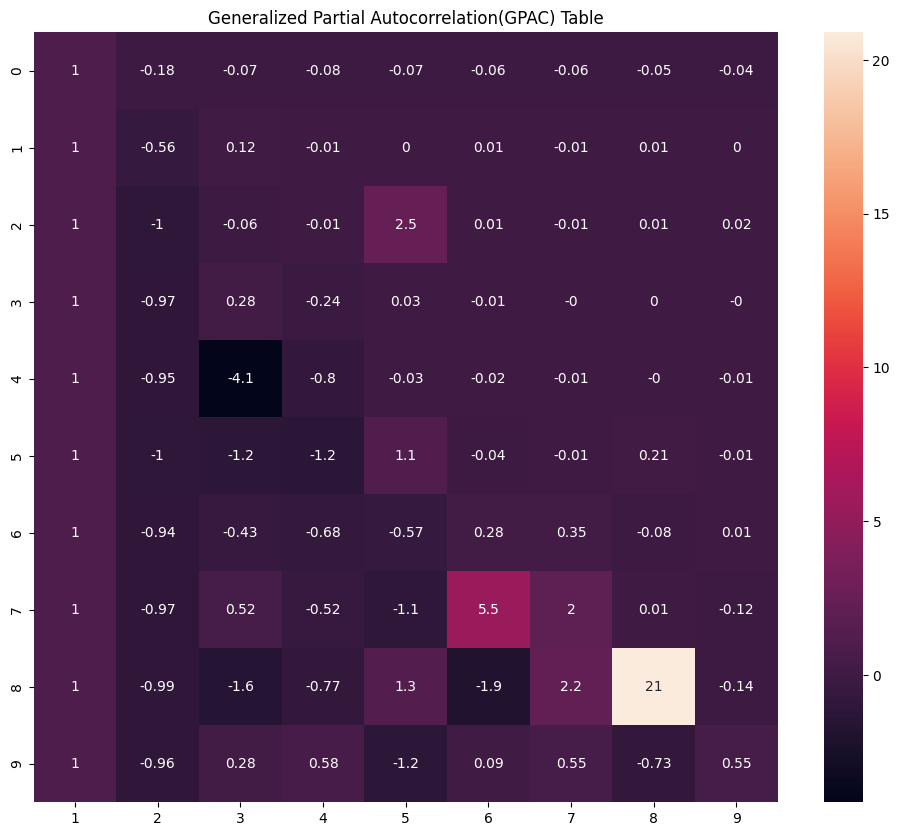

,1,2,3,4,5,6,7,8,9
0,1.0,-0.18,-0.07,-0.08,-0.07,-0.06,-0.06,-0.05,-0.04
1,1.0,-0.56,0.12,-0.01,0.00,0.01,-0.01,0.01,0.00
2,1.0,-1.02,-0.06,-0.01,2.51,0.01,-0.01,0.01,0.02
3,1.0,-0.97,0.28,-0.24,0.03,-0.01,-0.00,0.00,-0.00
4,1.0,-0.95,-4.14,-0.80,-0.03,-0.02,-0.01,-0.00,-0.01
5,1.0,-1.02,-1.18,-1.21,1.07,-0.04,-0.01,0.21,-0.01
6,1.0,-0.94,-0.43,-0.68,-0.57,0.28,0.35,-0.08,0.01
7,1.0,-0.97,0.52,-0.52,-1.07,5.50,2.02,0.01,-0.12
8,1.0,-0.99,-1.65,-0.77,1.33,-1.94,2.20,20.90,-0.14
9,1.0,-0.96,0.28,0.58,-1.18,0.09,0.55,-0.73,0.55


In [24]:
GPAC_table(train, J=10, K=10)

### 1. AR model 

In [ ]:
# Based on the ACF/PACF plot, it shows clear AR patter with ACF tail off and PACF cut off, statistical significance at order 1 and 2. The GPAC also shows AR order 1 or 2. The data is stationary, so we can fit into the AR model directly. 

In [12]:
# First try AR(1), calculate the MSE
model_ar_1 = ARIMA_model(AR_order=1)
model_ar_1.fit(train)

# prediction
prediction = model_ar_1.predict(train)
# prediction MSE
print('prediction error:', MSE(train, prediction))

forecast_test = model_ar_1.forecast(len(test))
print('test error:', MSE(test, forecast_test))


prediction error: 0.2012323293506882
test error: 80.65694460750417
validation error: 40.62581354538912


In [21]:
# try AR(2), calculate the MSE
model_ar_2 = ARIMA_model(AR_order=2)
model_ar_2.fit(train)

# prediction
prediction = model_ar_2.predict(train)
# prediction MSE
print('prediction error:', MSE(train, prediction))

forecast_test = model_ar_2.forecast(len(test))
print('test error:', MSE(test, forecast_test))


prediction error: 0.1949113109902796
test error: 80.5176612315395
validation error: 41.35865100108722


In [ ]:
# use customize Grid search code to find the AR order, the initial stage would be AR=1, we will try 1 - 20

In [4]:
final_order, mse_test = cus_grid_search_ar(train, test, 1, 10)

In [6]:
final_order, mse_test[3]

(4, (4, 80.4646), (4, 41.9088))

In [7]:
# the final order with grid search would be 4
model_ar_4 = ARIMA_model(AR_order=4)
model_ar_4.fit(train)

# prediction
prediction = model_ar_4.predict(train)
# prediction MSE
print('prediction error:', MSE(train, prediction))

forecast_test = model_ar_4.forecast(len(test))
print('test error:', MSE(test, forecast_test))

prediction error: 0.1928097717783925
test error: 80.4646155356582
validation error: 41.908809137020214


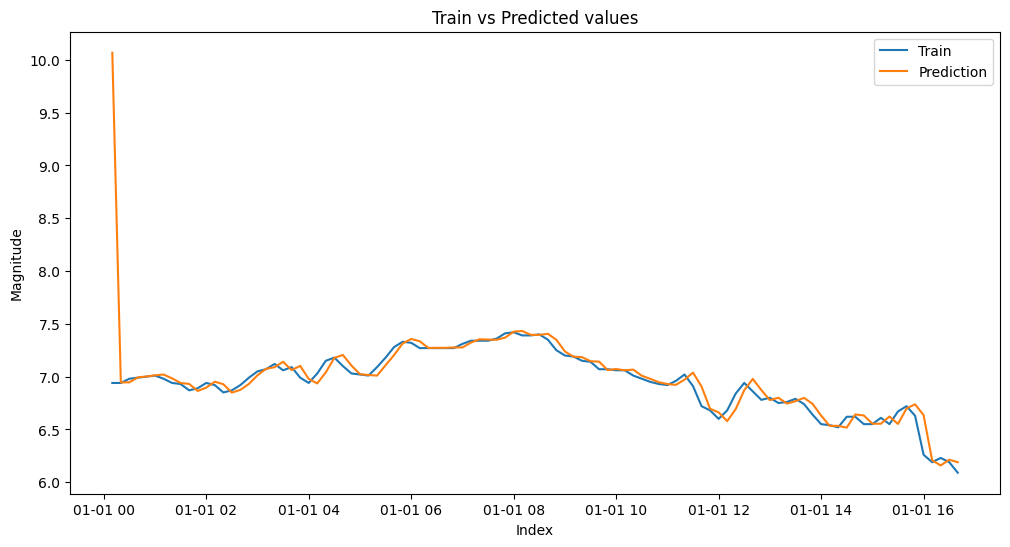

In [23]:
plt_prediction(df_train[:100], prediction[:100])

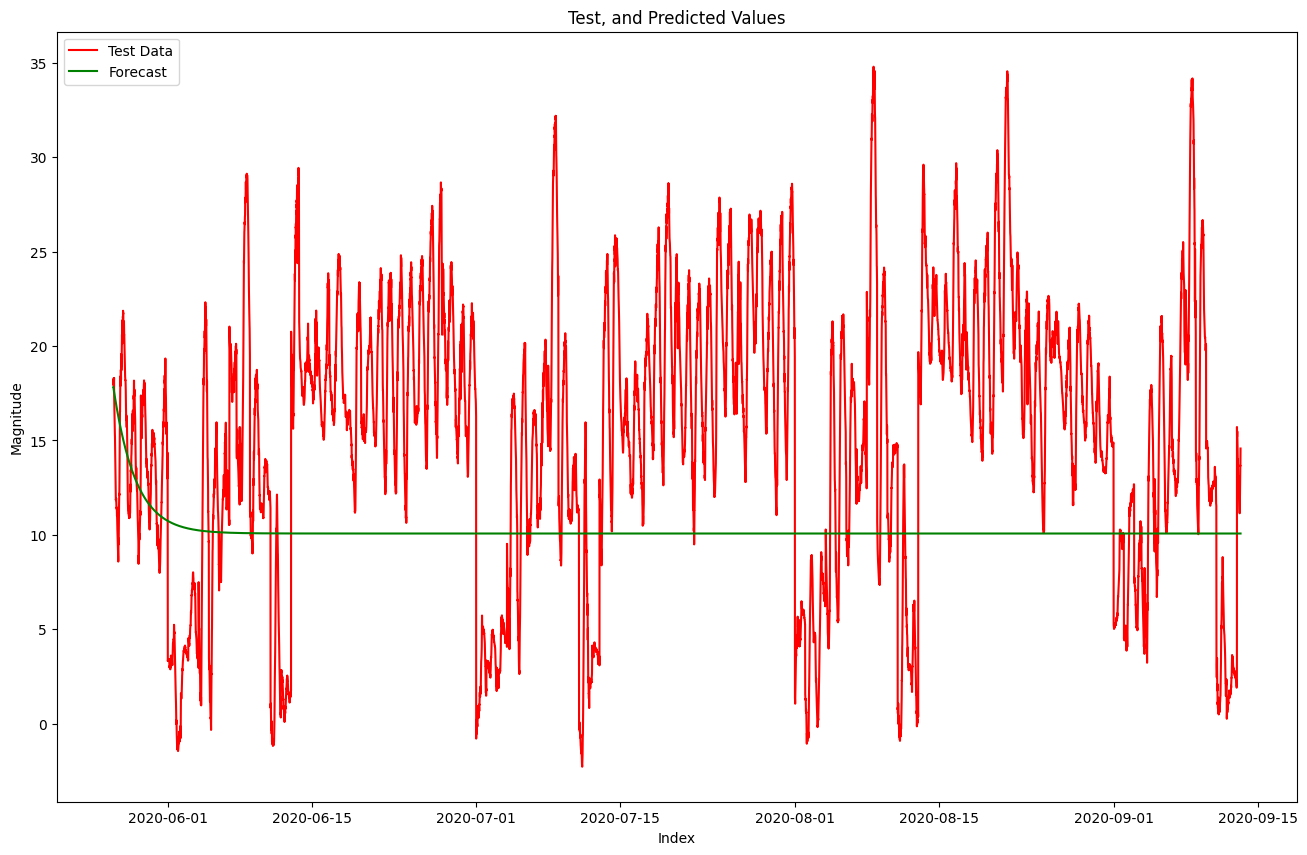

In [24]:
plt_forecast(df_test, forecast_test)

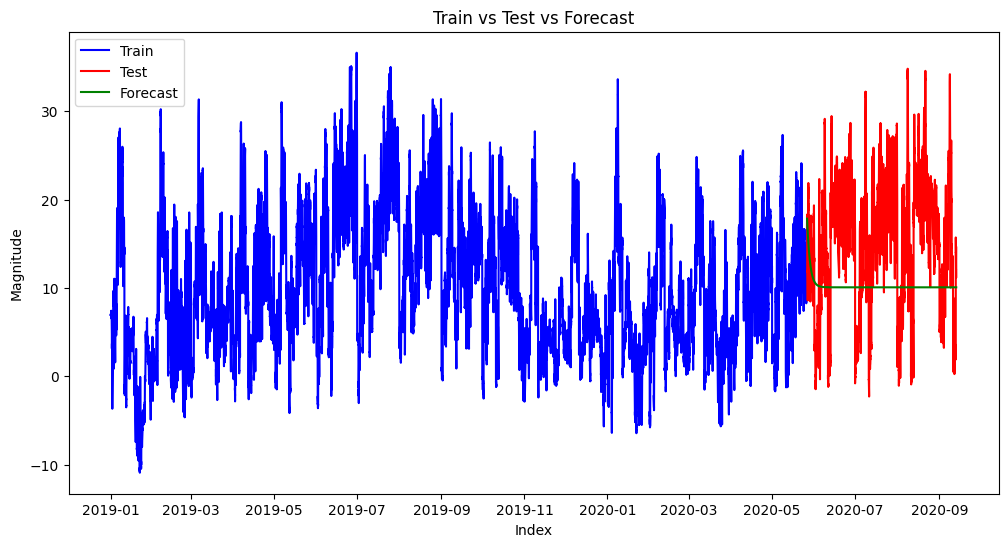

In [25]:
plt_train_test_forecast(df_train, df_test, forecast_test)

In [26]:
# prediction error
error, error_mean, error_var, error_mse = cal_err(prediction.tolist(), train[:, 0].tolist())

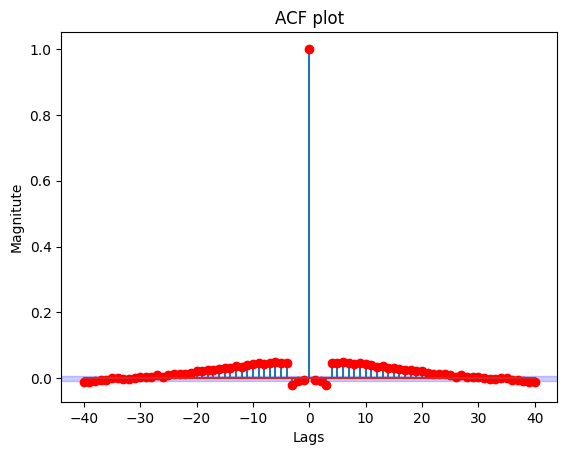

In [27]:
plt_ACF(error, 40)

In [28]:
error, error_mean, error_var, error_mse = cal_err(forecast_test.tolist(), test[:, 0].tolist())

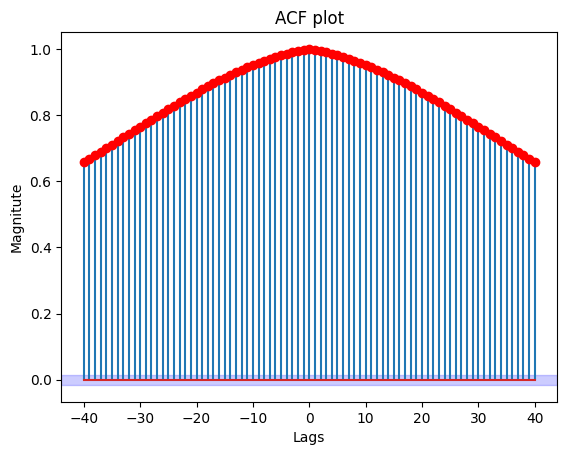

In [29]:
plt_ACF(error, 40)

### 2. MA model

In [ ]:
# since the ACF/PACF shows pattern for AR, for MA order, we will use grid search start with order 1

In [12]:
final_order, mse_test = cus_grid_search_ma(train, test, 1, 10)

/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/.local/lib/python3.12/site-

In [13]:
final_order, mse_test

(5,
 [(1, 81.03165547730143),
  (2, 81.02937659074337),
  (3, 81.02783671834692),
  (4, 81.02660655881888),
  (5, 81.02165960649097)],
 [(1, 44.27093087861321),
  (2, 44.27015527655445),
  (3, 44.26958133733272),
  (4, 44.269003119352604),
  (5, 44.266922190248195)])

In [14]:
final_order, mse_test = cus_grid_search_ma(train, test, 6, 10)

/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/.local/lib/python3.12/site-

In [16]:
final_order, mse_test = cus_grid_search_ma(train, test, 10, 15)

/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/.local/lib/python3.12/site-

In [18]:
final_order, mse_test= cus_grid_search_ma(train, test, 15, 20)

/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/.local/lib/python3.12/site-packages/

In [30]:
model_ma = ARIMA_model(AR_order=0, MA_order=20)
model_ma.fit(train)

# prediction
prediction = model_ma.predict(train)
# prediction MSE
print('prediction error:', MSE(train, prediction))

forecast_test = model_ma.forecast(len(test))
print('test error:', MSE(test, forecast_test))

/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction error: 0.2548797714706238
test error: 80.99153276867168
validation error: 44.2418765310934


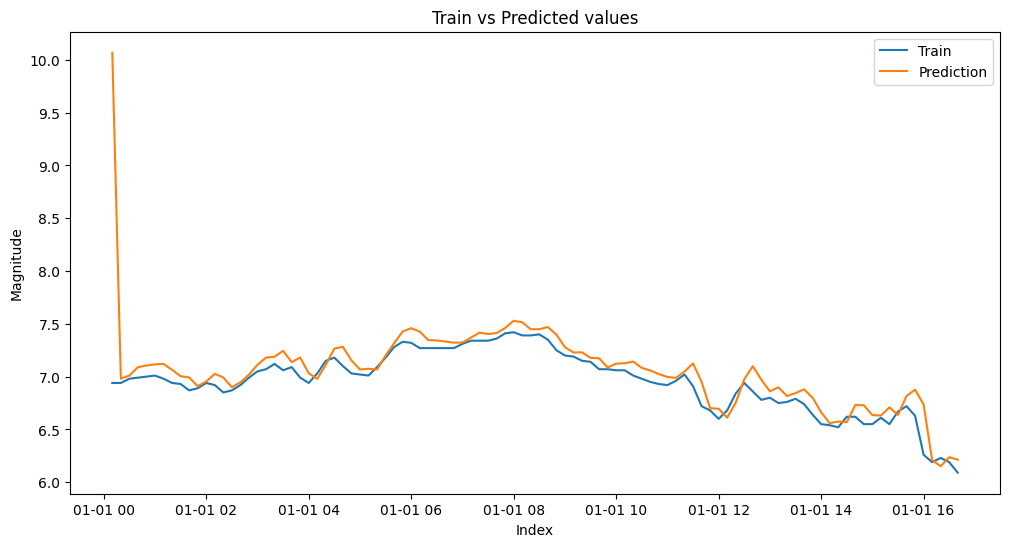

In [32]:
plt_prediction(df_train[:100], prediction[:100])

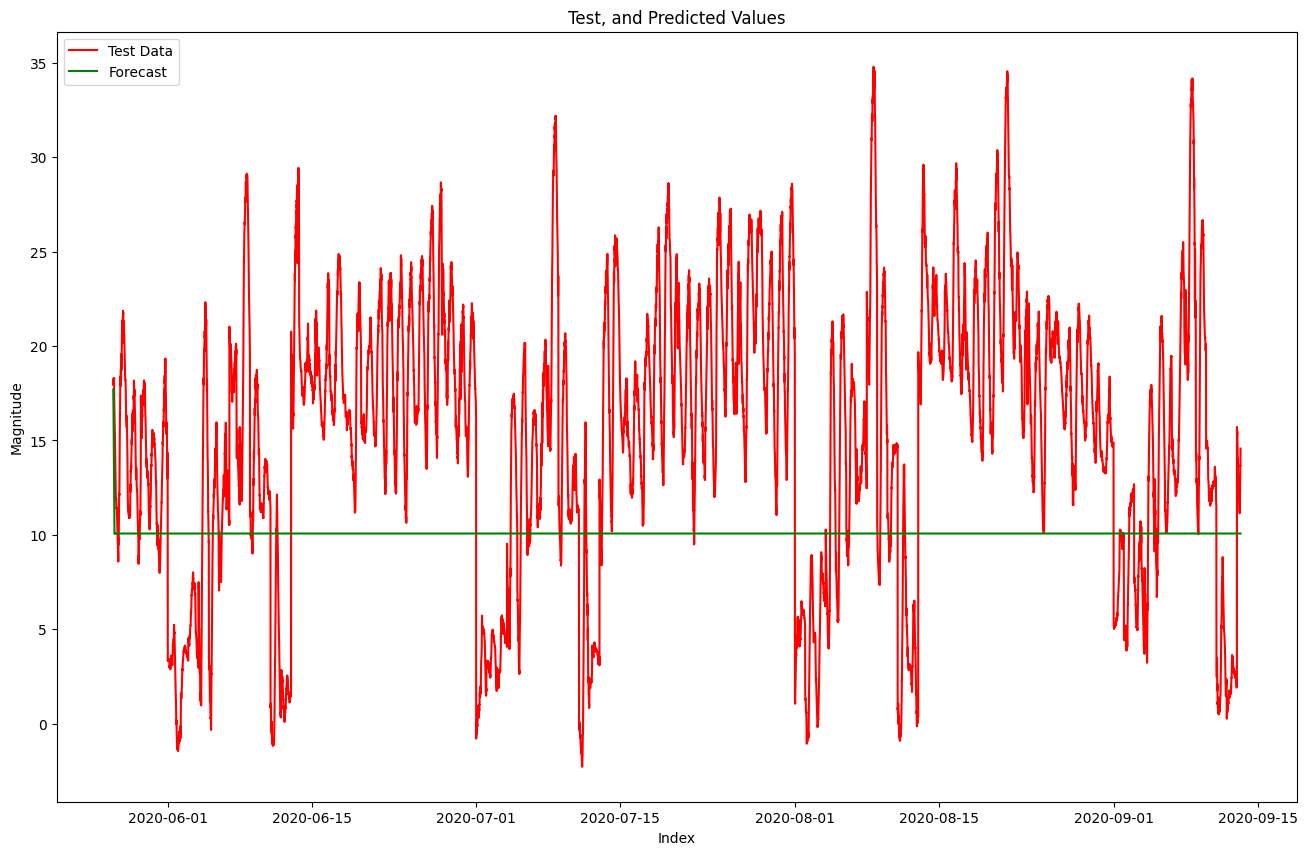

In [37]:
plt_forecast(df_test, forecast_test)

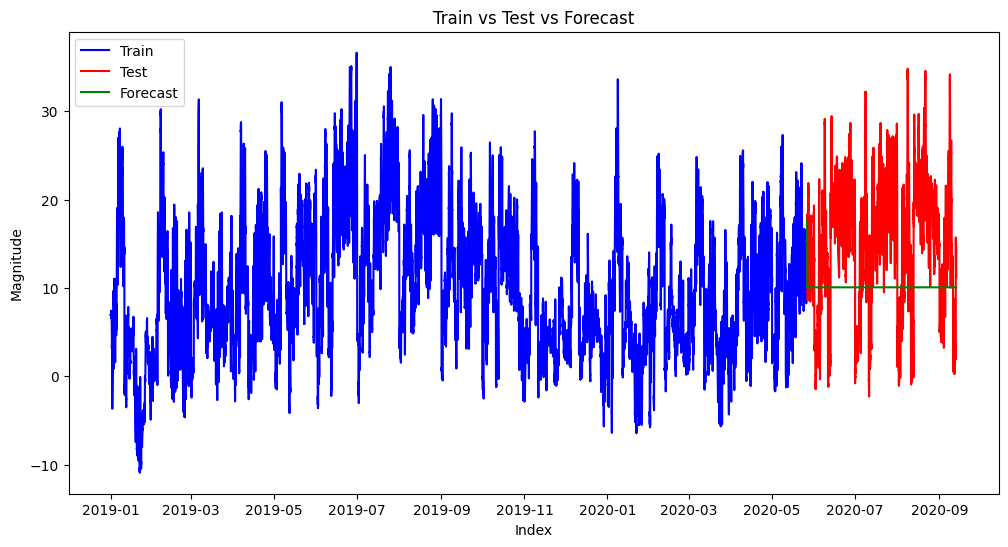

In [38]:
plt_train_test_forecast(df_train, df_test, forecast_test)

In [35]:
error, error_mean, error_var, error_mse = cal_err(prediction.tolist(), train[:, 0].tolist())

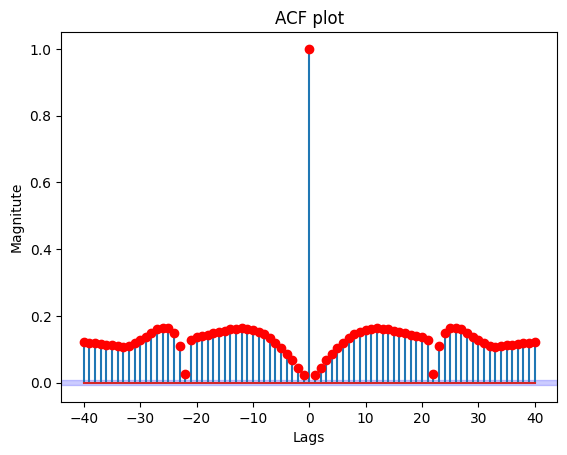

In [36]:
plt_ACF(error, 40)

In [33]:
error, error_mean, error_var, error_mse = cal_err(forecast_test.tolist(), test[:, 0].tolist())

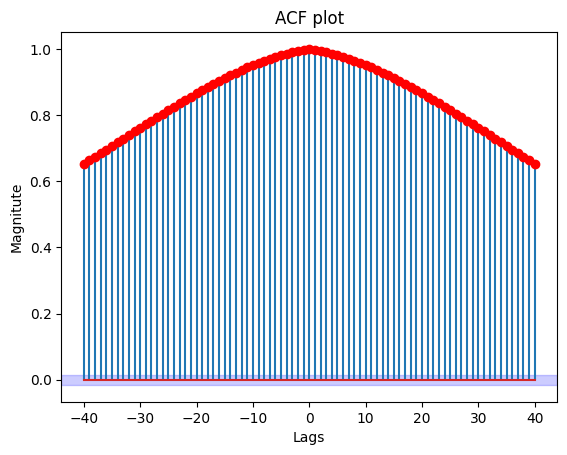

In [34]:
plt_ACF(error, 40)

### 3. ARMA

In [39]:
# The GPAC shows a order of ARMA(2,3)
model_arma = ARIMA_model(AR_order=2, MA_order=3)
model_arma.fit(train)

# prediction
prediction = model_arma.predict(train)
# prediction MSE
print('prediction error:', MSE(train, prediction))

forecast_test = model_arma.forecast(len(test))
print('test error:', MSE(test, forecast_test))

/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction error: 0.1946113911679422
test error: 80.01478955664433
validation error: 41.8479123814648


In [4]:
optuna_search_ARIMA(data,
                        ar_max=10, ma_max=10, integ_order=0,
                        objective=ARIMA_objective, n_trials=10)

[I 2024-10-22 01:45:02,003] A new study created in memory with name: no-name-c3830980-49e4-42bd-8368-ec050b47c310
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

Best parameters: {'AR_order': 6, 'MA_order': 6}
Best MSE: 125.59507680229417


(<optuna.study.study.Study at 0x703cf421ffb0>, ['AR_order', 'MA_order'])

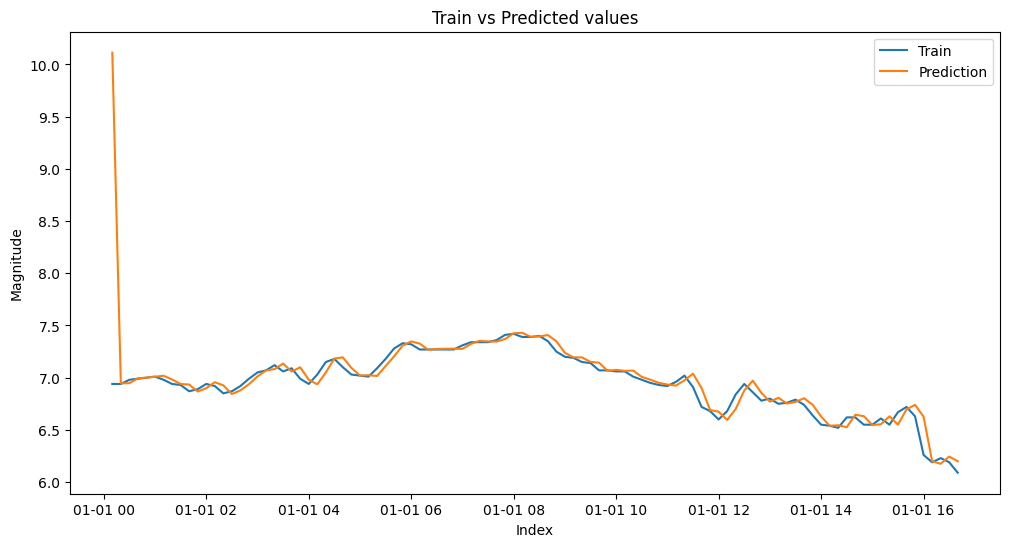

In [40]:
plt_prediction(df_train[:100], prediction[:100])

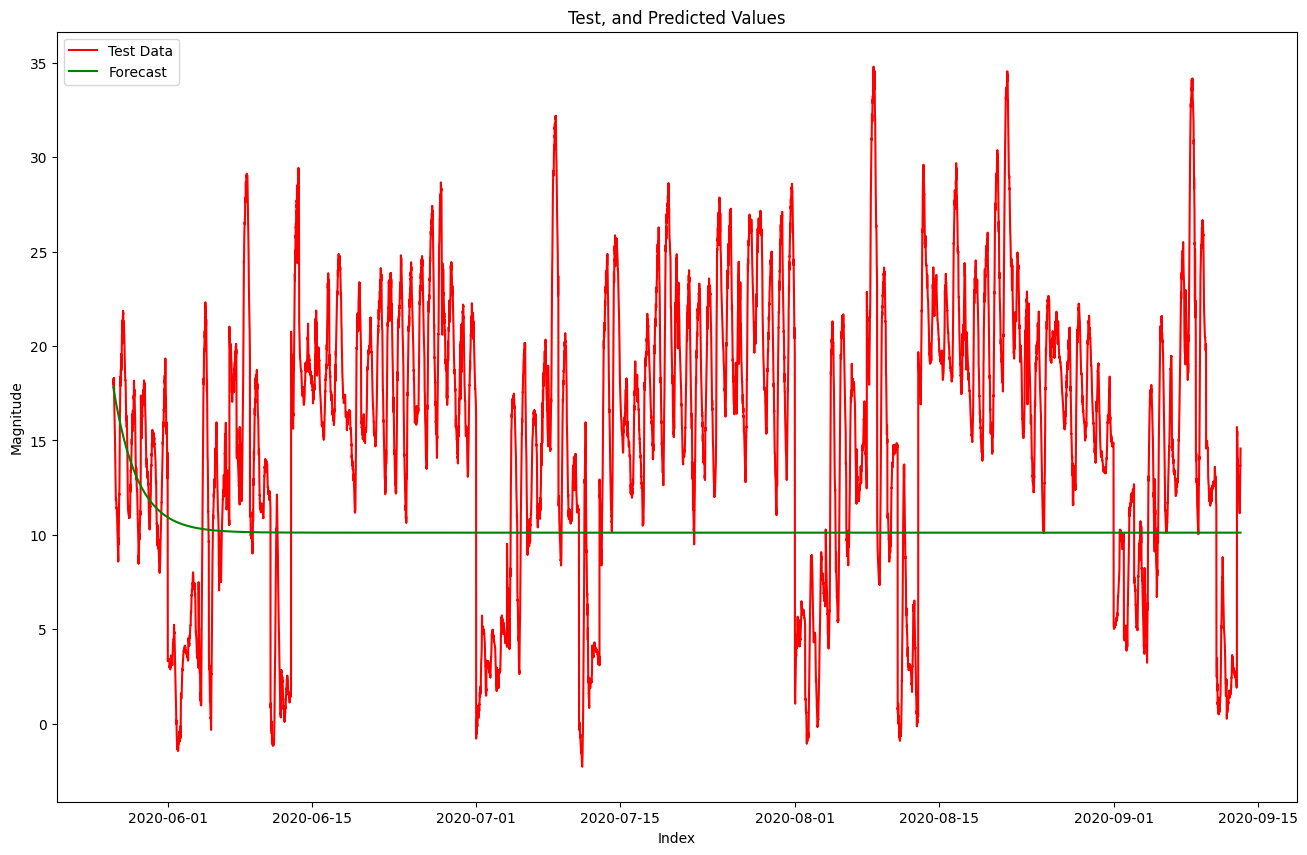

In [41]:
plt_forecast(df_test, forecast_test)

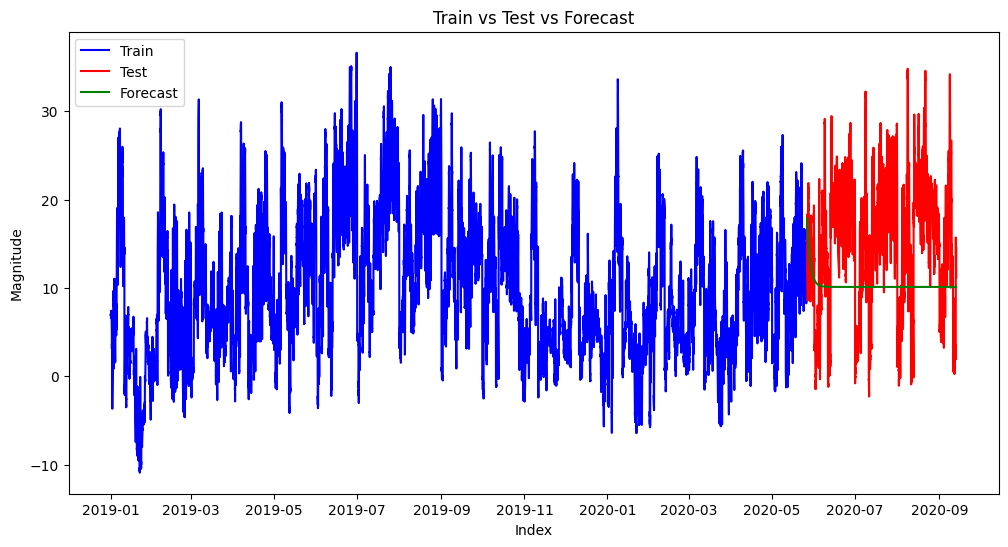

In [42]:
plt_train_test_forecast(df_train, df_test, forecast_test)

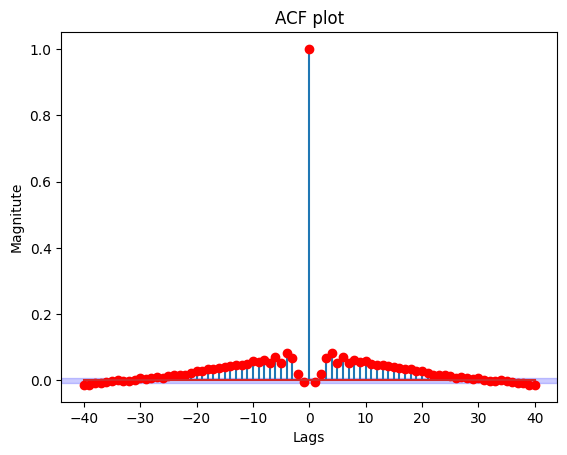

In [44]:
error, error_mean, error_var, error_mse = cal_err(prediction.tolist(), data[:, 0].tolist())
plt_ACF(error, 40)

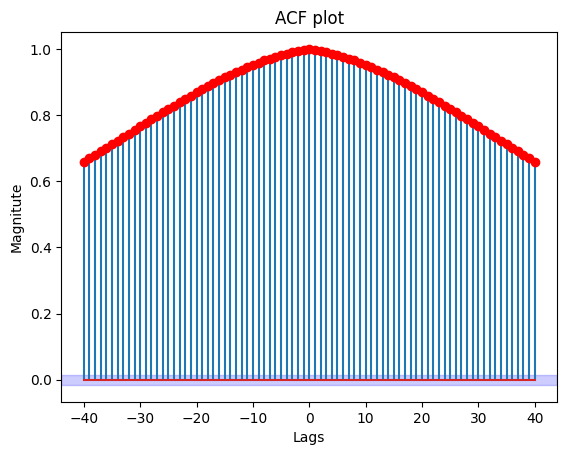

In [45]:
error, error_mean, error_var, error_mse = cal_err(forecast_test.tolist(), test[:, 0].tolist())
plt_ACF(error, 40)

### 4. ARIMA

In [65]:
def differencing(df, order, item):
    diff_list = [0] * order
    for i in range(order, len(df)):
        diff = df.iloc[i][item] - df.iloc[i-order][item]
        diff_list.append(diff)
    return diff_list


# reverse differencing
def rev_diff(value, forecast):
    rev_forecast = []
    for i in range(0, len(forecast)):
        value += forecast[i]
        rev_forecast.append(value)
    return rev_forecast


In [66]:
# perform first differencing
train_diff = df_train.copy()
diff_1st = differencing(train_diff, 1, 'temperature')

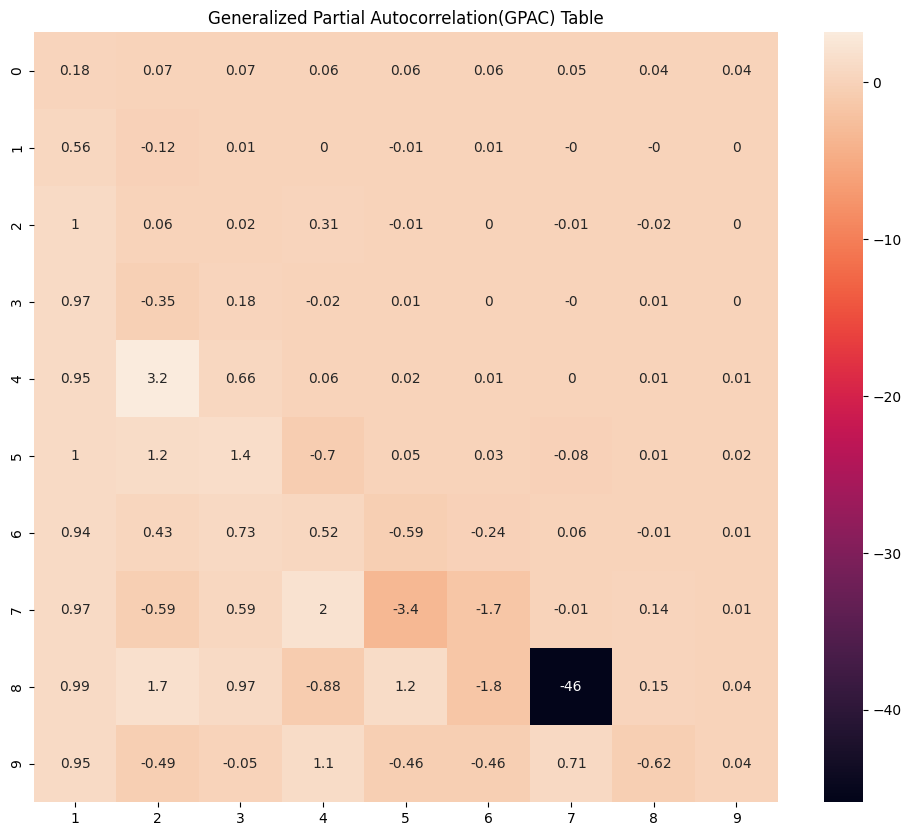

,1,2,3,4,5,6,7,8,9
0,0.18,0.07,0.07,0.06,0.06,0.06,0.05,0.04,0.04
1,0.56,-0.12,0.01,0.00,-0.01,0.01,-0.00,-0.00,0.00
2,1.01,0.06,0.02,0.31,-0.01,0.00,-0.01,-0.02,0.00
3,0.97,-0.35,0.18,-0.02,0.01,0.00,-0.00,0.01,0.00
4,0.95,3.19,0.66,0.06,0.02,0.01,0.00,0.01,0.01
5,1.01,1.17,1.36,-0.70,0.05,0.03,-0.08,0.01,0.02
6,0.94,0.43,0.73,0.52,-0.59,-0.24,0.06,-0.01,0.01
7,0.97,-0.59,0.59,1.96,-3.41,-1.70,-0.01,0.14,0.01
8,0.99,1.70,0.97,-0.88,1.25,-1.77,-45.89,0.15,0.04
9,0.95,-0.49,-0.05,1.11,-0.46,-0.46,0.71,-0.62,0.04


In [71]:
GPAC_table(diff_1st, J=10, K=10)

In [76]:
# The GPAC shows a order of ARMA(2,3)
model_arima = ARIMA_model(AR_order=1, MA_order=2, Inte_order=1)
model_arima.fit(train)

# prediction
prediction = model_arima.predict(train)
# prediction MSE
print('prediction error:', MSE(train, prediction))

forecast_test = model_arima.forecast(len(test))
print('test error:', MSE(test, forecast_test))

prediction error: 0.19008147177750173
test error: 65.48256170946074
validation error: 133.74525739000703


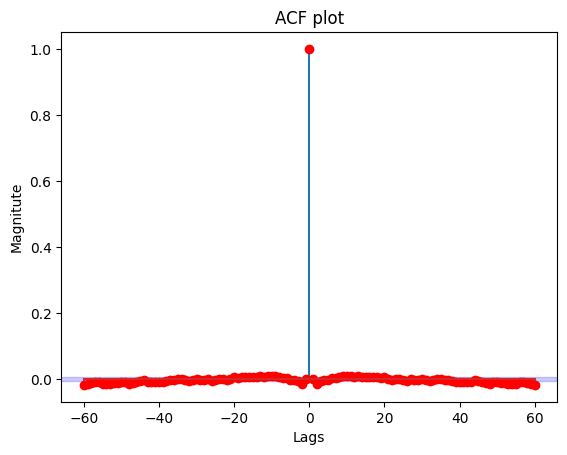

In [81]:
error, error_mean, error_var, error_mse = cal_err(prediction.tolist(), train[:, 0].tolist())
plt_ACF(error, 60)

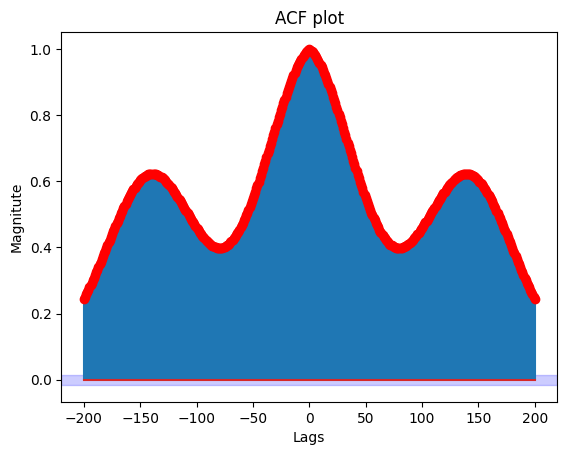

In [85]:
error, error_mean, error_var, error_mse = cal_err(forecast_test.tolist(), test[:, 0].tolist())
plt_ACF(error, 200)

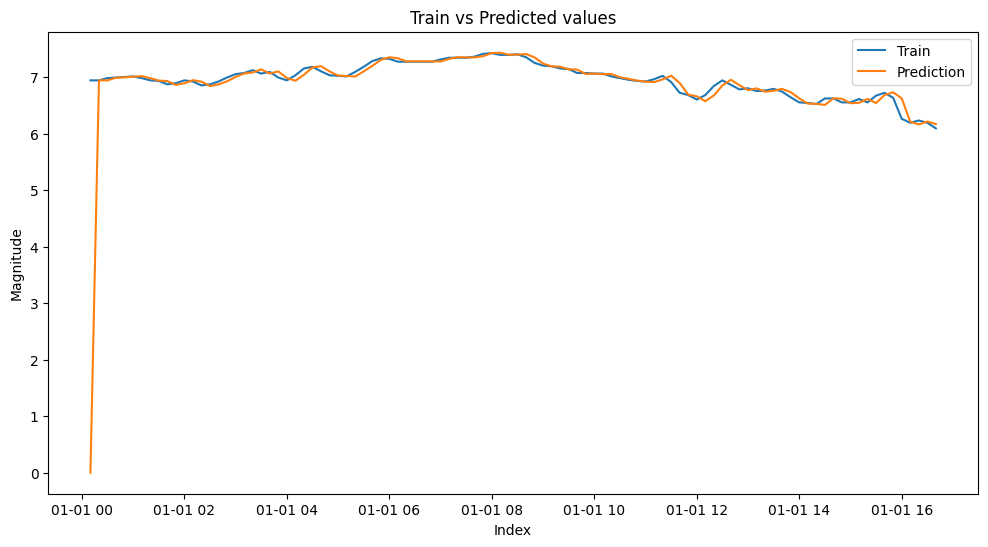

In [87]:
plt_prediction(df_train[:100], prediction[:100])

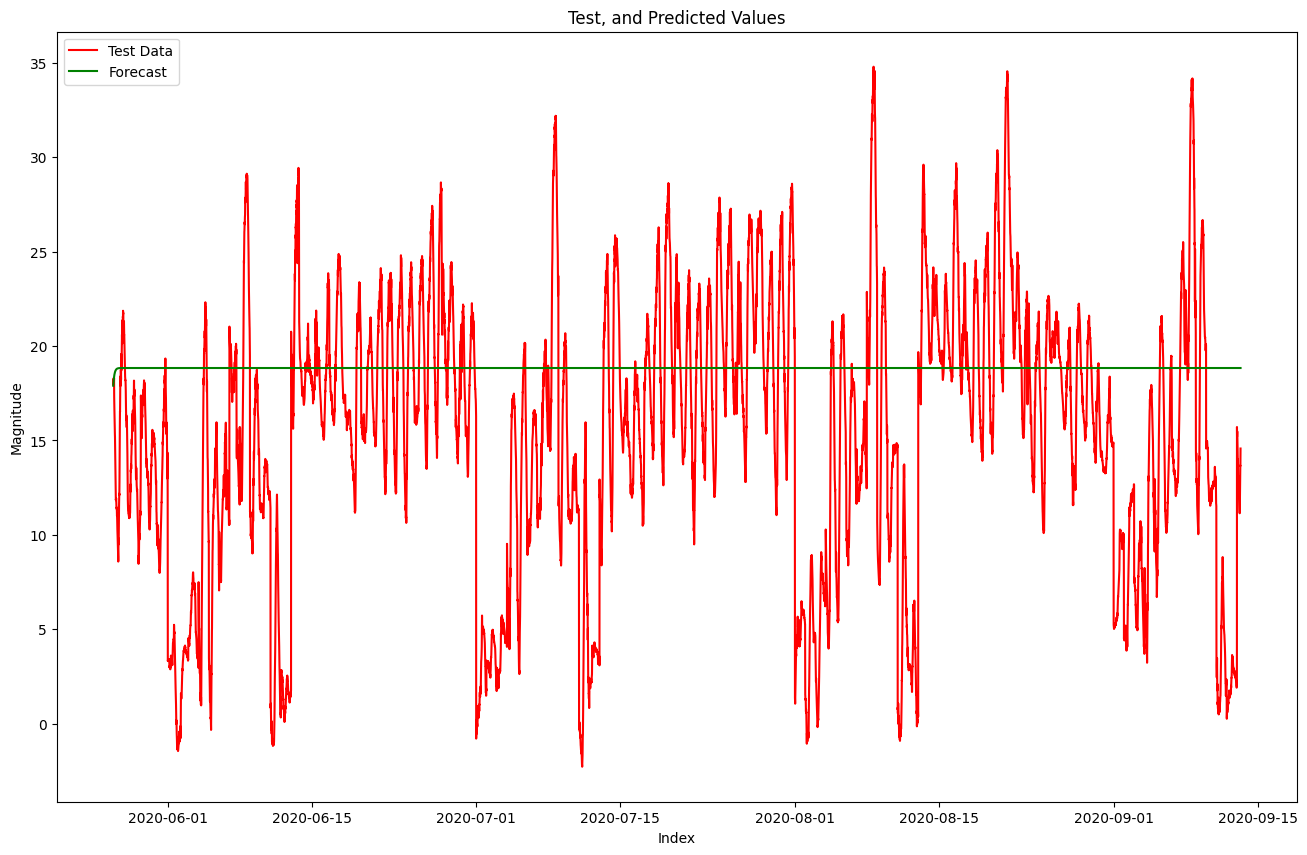

In [86]:
plt_forecast(df_test, forecast_test)

In [90]:
optuna_search_ARIMA(data,
                        ar_max=10, ma_max=10, integ_order=2,
                        objective=ARIMA_objective, n_trials=10)

[I 2024-10-21 22:00:04,632] A new study created in memory with name: no-name-675175f2-a8f1-4cfb-a37b-f2d860aaac2e
[I 2024-10-21 22:00:43,793] Trial 0 finished with value: 126.51351766719816 and parameters: {'AR_order': 1, 'MA_order': 7}. Best is trial 0 with value: 126.51351766719816.
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-10-21 22:01:31,528] Trial 1 finished with value: 126.513204905687 and parameters: {'AR_order': 3, 'MA_order': 5}. Best is trial 1 with value: 126.513204905687.
[I 2024-10-21 22:03:15,604] Trial 2 finished with value: 126.51112133514621 and para

Best parameters: {'AR_order': 3, 'MA_order': 0}
Best MSE: 126.23587198492336


(<optuna.study.study.Study at 0x7b28891f5ca0>, ['AR_order', 'MA_order'])

In [91]:
optuna_search_ARIMA(data,
                        ar_max=10, ma_max=10, integ_order=1,
                        objective=ARIMA_objective, n_trials=10)

[I 2024-10-21 23:39:46,412] A new study created in memory with name: no-name-79206431-8813-4a78-a6a1-c628c1a3b47a
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

Best parameters: {'AR_order': 6, 'MA_order': 0}
Best MSE: 126.06442554805906


(<optuna.study.study.Study at 0x7b27fa8d4e90>, ['AR_order', 'MA_order'])

In [92]:
arima = ARIMA_model(AR_order=6, MA_order=0, Inte_order=1)
arima.fit(train)

# prediction
prediction = arima.predict(train)
# prediction MSE
print('prediction error:', MSE(train, prediction))

forecast_test = arima.forecast(len(test))
print('test error:', MSE(test, forecast_test))

prediction error: 0.19163556175195093
test error: 60.50739614709248
validation error: 119.13292791112832


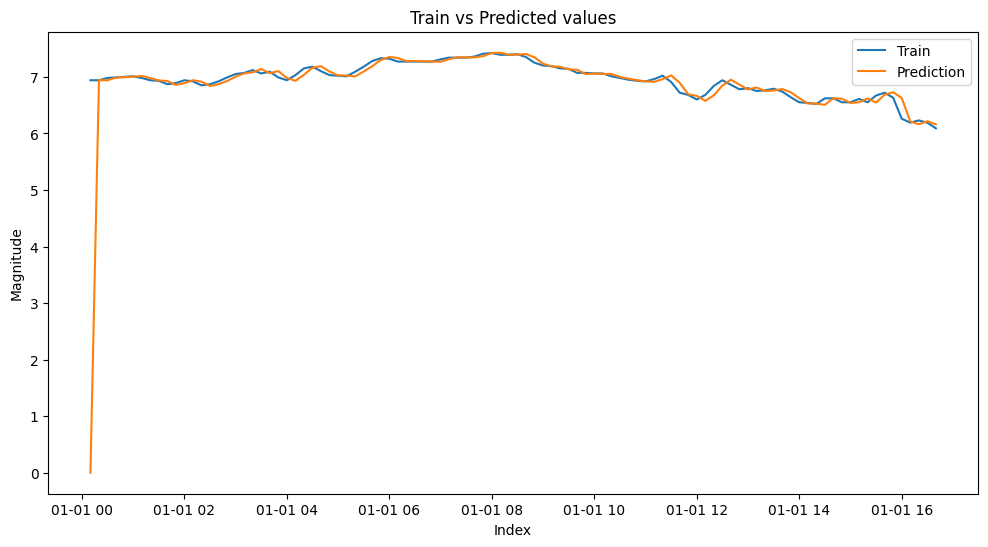

In [93]:
plt_prediction(df_train[:100], prediction[:100])

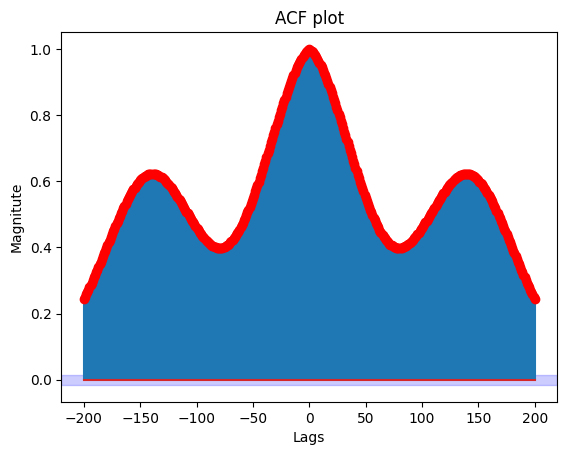

In [94]:
error, error_mean, error_var, error_mse = cal_err(forecast_test.tolist(), test[:, 0].tolist())
plt_ACF(error, 200)

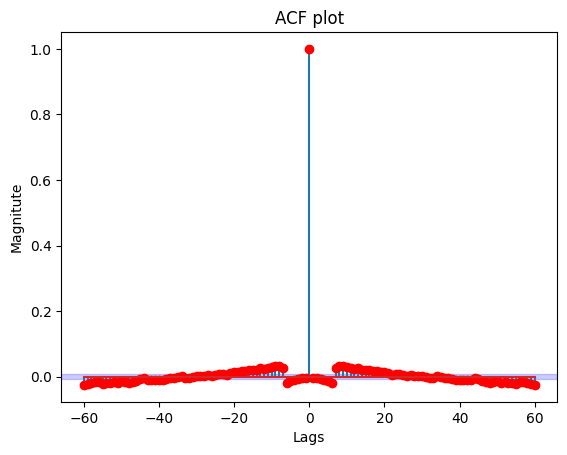

In [95]:
error, error_mean, error_var, error_mse = cal_err(prediction.tolist(), train[:, 0].tolist())
plt_ACF(error, 60)